<a href="https://colab.research.google.com/github/ParthBansal23/Pawspective/blob/main/Pawspective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DOG BREED CLASSIFICATION (Image Classification)

TEAM MEMBERS :-   


1.   Maulik Mathur  22UCS121
2.   Parth Bansal   22UCS146
3.   Samarth Garg   22UCS175



**Project:** Dog Vision : Using computer vision to classify dog photos into different breeds.

For this prject, we are taking data from the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) (120 dog breeds, 20,000+ images).

It is a multi-class classification (120 different classes).

For this, we are using Tensorflow/Keras.

We will first do dataset preparation, then we will build a model and then will train and evaluate the model.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Getting the GPU

In [ ]:
import tensorflow as tf
tf.__version__

'2.17.1'

In [ ]:
device_list = tf.config.list_physical_devices()
if "GPU" in [device.device_type for device in device_list]:
  print(f"[INFO] TensorFlow has GPU available to use.")
  print(f"[INFO] Accessible devices:\n{device_list}")
else:
  print(f"[INFO] TensorFlow does not have GPU available to use.")
  print(f"[INFO] Accessible devices:\n{device_list}")

[INFO] TensorFlow has GPU available to use.
[INFO] Accessible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Downloading data from the Stanford Dogs website

The data came in three main files:

1. [Images](http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar) (757MB) - `images.tar`
3. [Annotations](http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar) (21MB) - `annotation.tar`
3. [Lists](http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar) with train/test splits (0.5MB) - `lists.tar`

Now we will mount drive so that we don't have to keep redownloading the data every time we leave


In [ ]:
from pathlib import Path
from google.colab import drive

drive.mount("/content/drive")

TARGET_DRIVE_PATH = Path("drive/MyDrive/tensorflow/dog_vision_data")
TARGET_FILES = ["images.tar", "annotation.tar", "lists.tar"]
TARGET_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs"

local_dir = Path("dog_vision_data")

if all((TARGET_DRIVE_PATH / file).is_file() for file in TARGET_FILES):
  print(f"[INFO] Copying Dog Vision files from Google Drive to local directory...")
  print(f"[INFO] Source dir: {TARGET_DRIVE_PATH} -> Target dir: {local_dir}")
  !cp -r {TARGET_DRIVE_PATH} .
  print("[INFO] Good to go!")

else:
  print(f"[INFO] Target files not found in Google Drive.")
  print(f"[INFO] Downloading the target files... this shouldn't take too long...")
  for file in TARGET_FILES:
    !wget -nc {TARGET_URL}/{file} -P {local_dir}

  print(f"[INFO] Saving the target files to Google Drive, so they can be loaded later...")

  TARGET_DRIVE_PATH.mkdir(parents=True, exist_ok=True)

  !cp -r {local_dir}/* {TARGET_DRIVE_PATH}/

In [ ]:
if local_dir.exists():
  print(str(local_dir) + "/")
  for item in local_dir.iterdir():
    print("  ", item.name)

In [ ]:
# Untaring images, notes/tags:
# -x = extract files from the zipped file
# -v = verbose
# -z = decompress files
# -f = tell tar which file to deal with
!tar -xf dog_vision_data/images.tar
!tar -xf dog_vision_data/annotation.tar
!tar -xf dog_vision_data/lists.tar

In [ ]:
import os

os.listdir(".") # "." means "here" or "current directory"


* `train_list.mat` - a list of all the training set images.
* `test_list.mat` - a list of all the testing set images.
* `Images/` - a folder containing all of the images of dogs.
* `Annotation/` - a folder containing all of the annotations for each image.
* `file_list.mat` - a list of all the files (training and test list combined).



## Exploring the data


### Exploring the file lists

We can use the scipy library to open a .mat file

In [ ]:
import scipy

# Opening lists of train and test .mat
train_list = scipy.io.loadmat("train_list.mat")
test_list = scipy.io.loadmat("test_list.mat")
file_list = scipy.io.loadmat("file_list.mat")

train_list, type(train_list)

In [ ]:
train_list.keys()

In [ ]:
# Checking the length of the file_list key
print(f"Number of files in training list: {len(train_list['file_list'])}")
print(f"Number of files in testing list: {len(test_list['file_list'])}")
print(f"Number of files in full list: {len(file_list['file_list'])}")

In [ ]:
train_file_list = list([item[0][0] for item in train_list["file_list"]])
test_file_list = list([item[0][0] for item in test_list["file_list"]])
full_file_list = list([item[0][0] for item in file_list["file_list"]])

len(train_file_list), len(test_file_list), len(full_file_list)

### Exploring the Annotation folder

In [ ]:
os.listdir("Annotation")[:10]

In [ ]:
from pathlib import Path

def count_subfolders(directory_path: str) -> int:
    return len([name for name in Path(directory_path).iterdir() if name.is_dir()])

directory_path = "Annotation"
folder_count = count_subfolders(directory_path)
print(f"Number of subfolders in {directory_path} directory: {folder_count}")

There are 120 subfolders of annotations, one for each class of dog we'd like to identify.

### Exploring the Images folder


In [ ]:
# Getting a list of all image folders
image_folders = os.listdir("Images")
image_folders[:10]

In [ ]:
folder_to_class_name_dict = {}
for folder_name in image_folders:
  class_name = "_".join(folder_name.split("-")[1:]).lower()
  folder_to_class_name_dict[folder_name] = class_name

# Making sure there are 120 entries in the dictionary
assert len(folder_to_class_name_dict) == 120

In [ ]:
dog_names = sorted(list(folder_to_class_name_dict.values()))
dog_names[:10]

Now we've got:

1. `folder_to_class_name_dict` - a mapping from the folder name to the class name.
2. `dog_names` - a list of all the unique dog breeds we're working with.



### Exploring the distribution of our data

A balanced distribution would mean having roughly the same number of images for each breed (e.g. 100 images per dog breed).

To figure out how many images we have per class, we are writing a function to count the number of images per subfolder in a given directory.

In [ ]:
from pathlib import Path
from typing import List, Dict

def count_images_in_subdirs(target_directory: str) -> List[Dict[str, int]]:

    images_dir = Path(target_directory)
    image_class_dirs = [directory for directory in images_dir.iterdir() if directory.is_dir()]

    image_class_counts = []

    for image_class_dir in image_class_dirs:

        class_name = image_class_dir.stem

        image_count = len(list(image_class_dir.rglob("*.jpg")))

        image_class_counts.append({"class_name": class_name,
                                   "image_count": image_count})

    return image_class_counts

In [ ]:
image_class_counts = count_images_in_subdirs("Images")
image_class_counts[:3]

In [ ]:
import pandas as pd
image_counts_df = pd.DataFrame(image_class_counts).sort_values(by="image_count", ascending=False)
image_counts_df.head()

In [ ]:
# Making class name column easier to read
image_counts_df["class_name"] = image_counts_df["class_name"].map(folder_to_class_name_dict)
image_counts_df.head()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
image_counts_df.plot(kind="bar",
                     x="class_name",
                     y="image_count",
                     legend=False,
                     ax=plt.gca())

plt.ylabel("Image Count")
plt.title("Total Image Counts by Class")
plt.xticks(rotation=90,
           fontsize=8)
plt.tight_layout()
plt.show()

We can see that the classes are quite balanced. Each breed of dog has ~150 or more images.

In [ ]:
image_counts_df.describe()

## Creating training and test data split directories





In [ ]:
from pathlib import Path

images_split_dir = Path("images_split")
train_dir = images_split_dir / "train"
test_dir = images_split_dir / "test"

train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)
print(f"Directory {train_dir} is exists.")
print(f"Directory {test_dir} is exists.")

for dog_name in dog_names:
  train_class_dir = train_dir / dog_name
  train_class_dir.mkdir(parents=True, exist_ok=True)

  test_class_dir = test_dir / dog_name
  test_class_dir.mkdir(parents=True, exist_ok=True)

# Making sure there is 120 subfolders in each
assert count_subfolders(train_dir) == len(dog_names)
assert count_subfolders(test_dir) == len(dog_names)

In [ ]:
# Seeing the first 10 directories in the training split dir
sorted([str(dir_name) for dir_name in train_dir.iterdir() if dir_name.is_dir()])[:10]

In [ ]:
from pathlib import Path
from shutil import copy2
from tqdm.auto import tqdm

def copy_files_to_target_dir(file_list: list[str],
                             target_dir: str,
                             images_dir: str = "Images",
                             verbose: bool = False) -> None:
    for file in tqdm(file_list):

      source_file_path = Path(images_dir) / Path(file)

      file_class_name = folder_to_class_name_dict[Path(file).parts[0]]

      file_image_name = Path(file).name

      destination_file_path = Path(target_dir) / file_class_name / file_image_name

      destination_file_path.parent.mkdir(parents=True, exist_ok=True)

      if verbose:
        print(f"[INFO] Copying: {source_file_path} to {destination_file_path}")

      copy2(src=source_file_path, dst=destination_file_path)

In [ ]:
# Copying training images from Images to images_split/train/...
copy_files_to_target_dir(file_list=train_file_list,
                         target_dir=train_dir,
                         verbose=False)

In [ ]:
copy_files_to_target_dir(file_list=test_file_list,
                         target_dir=test_dir,
                         verbose=False)

In [ ]:
# Getting list of of all .jpg paths in train and test image directories
train_image_paths = list(train_dir.rglob("*.jpg"))
test_image_paths = list(test_dir.rglob("*.jpg"))

# Making sure the number of images in the training and test directories equals the number of files in their original lists
assert len(train_image_paths) == len(train_file_list)
assert len(test_image_paths) == len(test_file_list)

print(f"Number of images in {train_dir}: {len(train_image_paths)}")
print(f"Number of images in {test_dir}: {len(test_image_paths)}")

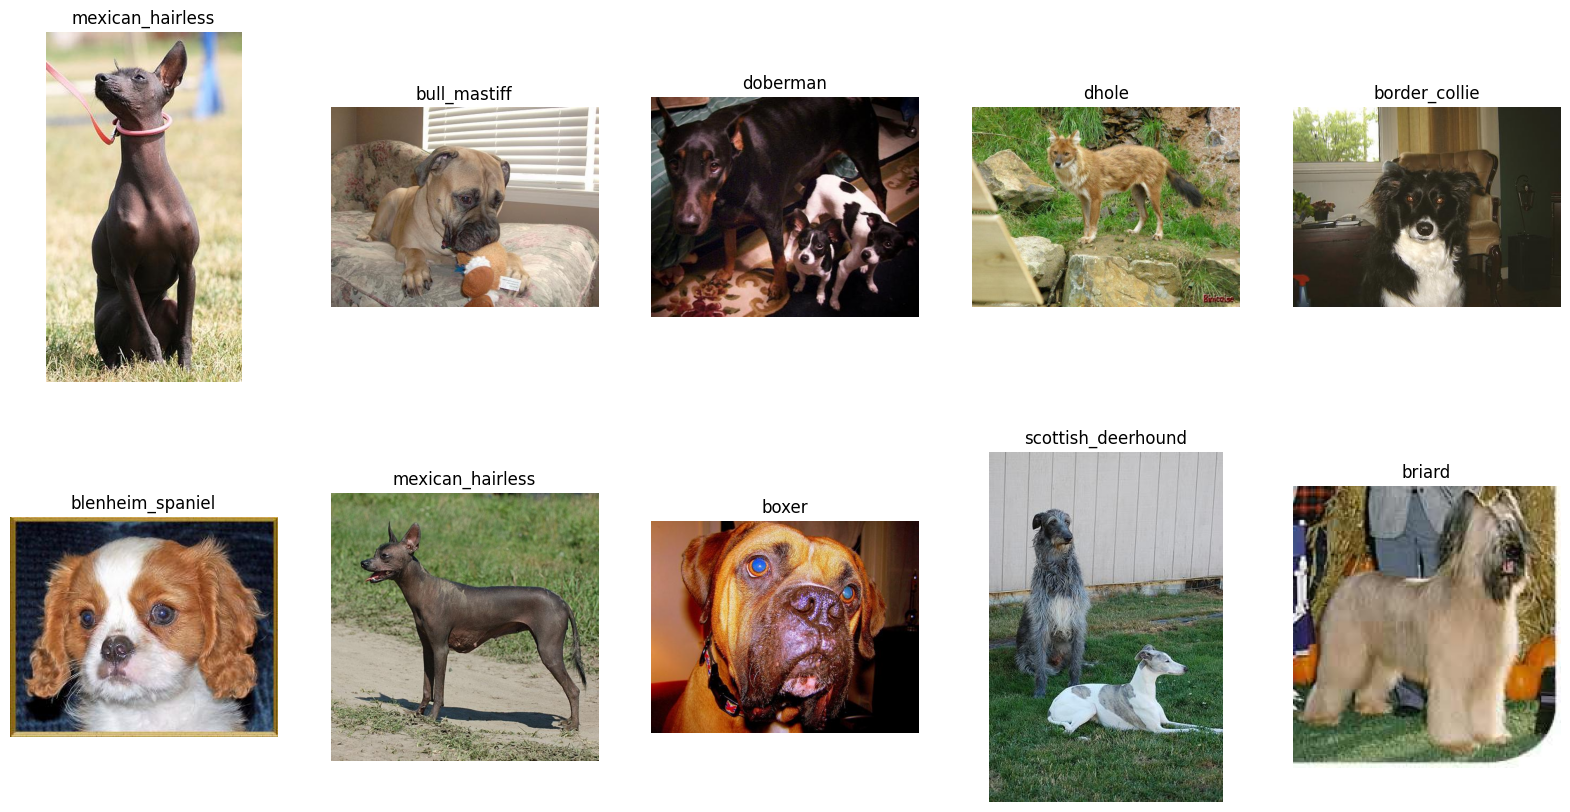

In [ ]:
# Plotting 10 random images from the train_image_paths
plot_10_random_images_from_path_list(path_list=train_image_paths,
                                     extract_title=False)

In [ ]:
train_10_percent_dir = images_split_dir / "train_10_percent"
train_10_percent_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
os.listdir(images_split_dir)

['train_10_percent', 'train', 'test']

In [ ]:
import random

random.seed(42)

train_image_paths_random_10_percent = random.sample(population=train_image_paths,
                                                    k=int(0.1*len(train_image_paths)))

print(f"Original number of training image paths: {len(train_image_paths)}")
print(f"Number of 10% training image paths: {len(train_image_paths_random_10_percent)}")
print("First 5 random 10% training image paths:")
train_image_paths_random_10_percent[:5]

Original number of training image paths: 12000
Number of 10% training image paths: 1200
First 5 random 10% training image paths:


[PosixPath('images_split/train/collie/n02106030_17733.jpg'),
 PosixPath('images_split/train/australian_terrier/n02096294_2175.jpg'),
 PosixPath('images_split/train/mexican_hairless/n02113978_1891.jpg'),
 PosixPath('images_split/train/norwich_terrier/n02094258_977.jpg'),
 PosixPath('images_split/train/standard_poodle/n02113799_1344.jpg')]

In [ ]:
for source_file_path in tqdm(train_image_paths_random_10_percent):

  destination_file_and_image_name = Path(*source_file_path.parts[-2:]) # "images_split/train/yorkshire_terrier/n02094433_2223.jpg" -> "yorkshire_terrier/n02094433_2223.jpg"
  destination_file_path = train_10_percent_dir / destination_file_and_image_name # "yorkshire_terrier/n02094433_2223.jpg" -> "images_split/train_10_percent/yorkshire_terrier/n02094433_2223.jpg"

  target_class_dir = destination_file_path.parent
  if not target_class_dir.is_dir():
    target_class_dir.mkdir(parents=True,
                           exist_ok=True)

  copy2(src=source_file_path,
        dst=destination_file_path)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
# Counting images in train_10_percent_dir
train_10_percent_image_class_counts = count_images_in_subdirs(train_10_percent_dir)
train_10_percent_image_class_counts_df = pd.DataFrame(train_10_percent_image_class_counts).sort_values("image_count", ascending=True)
train_10_percent_image_class_counts_df.head()

,class_name,image_count
33,entlebucher,3
64,cairn,4
23,giant_schnauzer,4
61,great_pyrenees,4
58,keeshond,5


In [ ]:
print(len(train_10_percent_image_class_counts_df))

120


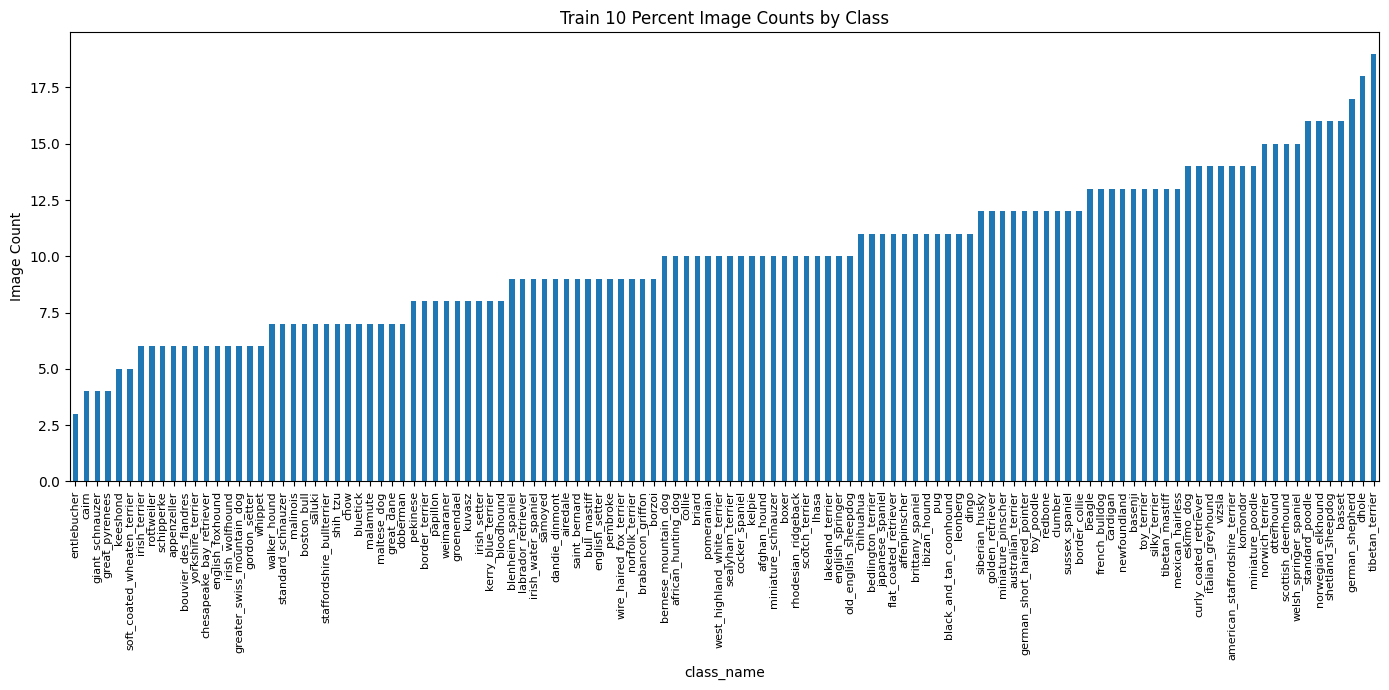

In [ ]:
plt.figure(figsize=(14, 7))
train_10_percent_image_class_counts_df.plot(kind="bar",
                     x="class_name",
                     y="image_count",
                     legend=False,
                     ax=plt.gca())

plt.title("Train 10 Percent Image Counts by Class")
plt.ylabel("Image Count")
plt.xticks(rotation=90,
           fontsize=8)
plt.tight_layout()
plt.show()

## Turning datasets into TensorFlow Datasets



In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_10_percent_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_10_percent_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

Found 1200 files belonging to 120 classes.
Found 12000 files belonging to 120 classes.
Found 8580 files belonging to 120 classes.


In [ ]:
train_10_percent_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [ ]:
image_batch, label_batch = next(iter(train_ds))
image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 120]))

In [ ]:
print(f"Single image tensor:\n{image_batch[0]}\n")
print(f"Single label tensor: {label_batch[0]}")
print(f"Single sample class name: {dog_names[tf.argmax(label_batch[0])]}")

Single image tensor:
[[[196.61607  174.61607  160.61607 ]
  [197.84822  175.84822  161.84822 ]
  [200.       178.       164.      ]
  ...
  [ 60.095097  79.75804   45.769207]
  [ 61.83293   71.22575   63.288315]
  [ 77.65755   83.65755   81.65755 ]]

 [[196.       174.       160.      ]
  [197.83876  175.83876  161.83876 ]
  [199.07945  177.07945  163.07945 ]
  ...
  [ 94.573715 110.55229   83.59694 ]
  [125.869865 135.26268  127.33472 ]
  [122.579605 128.5796   126.579605]]

 [[195.73691  173.73691  159.73691 ]
  [196.896    174.896    160.896   ]
  [199.       177.       163.      ]
  ...
  [ 26.679413  38.759026  20.500835]
  [ 24.372307  31.440136  26.675896]
  [ 20.214453  26.214453  24.214453]]

 ...

 [[ 61.57369   70.18976  104.72547 ]
  [189.91965  199.61607  213.28572 ]
  [247.26637  255.       252.70387 ]
  ...
  [113.40158   83.40158   57.40158 ]
  [110.75214   78.75214   53.752136]
  [107.37048   75.37048   50.370483]]

 [[ 61.27007   69.88614  104.42185 ]
  [188.93079  19

### Visualizing images from our TensorFlow Dataset



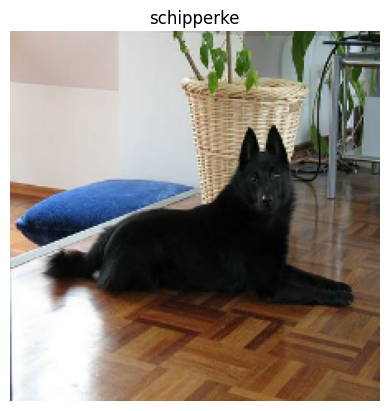

In [ ]:
plt.imshow(image_batch[0].numpy().astype("uint8"))
plt.title(dog_names[tf.argmax(label_batch[0])])
plt.axis("off");

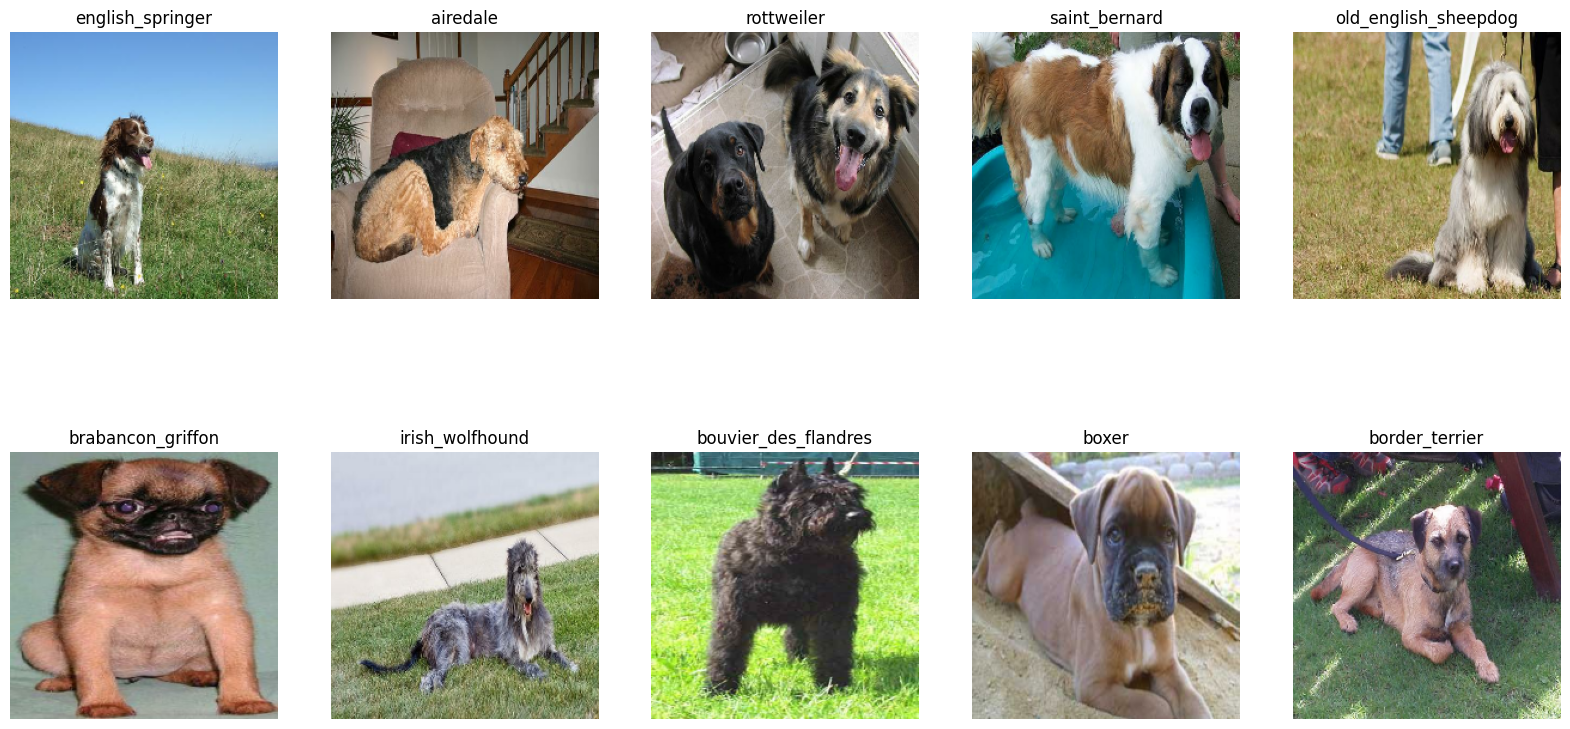

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

for images, labels in train_ds.take(count=1):
  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(dog_names[tf.argmax(labels[i])])
    ax.axis("off")

### Getting labels from our TensorFlow Dataset


In [ ]:
train_ds.file_paths[:5]

['images_split/train/boston_bull/n02096585_1753.jpg',
 'images_split/train/kerry_blue_terrier/n02093859_855.jpg',
 'images_split/train/border_terrier/n02093754_2281.jpg',
 'images_split/train/rottweiler/n02106550_11823.jpg',
 'images_split/train/airedale/n02096051_5884.jpg']

In [ ]:
class_names = train_ds.class_names
class_names[:5]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

In [ ]:
assert set(train_10_percent_ds.class_names) == set(train_ds.class_names) == set(test_ds.class_names)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_10_percent_ds = train_10_percent_ds.cache().shuffle(buffer_size=10*BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().shuffle(buffer_size=100*BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating a neural network with TensorFlow



In [ ]:
print(f"Number of layers in base_model: {len(base_model.layers)}")

Number of layers in base_model: 273


In [ ]:
base_model.input_shape

(None, 224, 224, 3)

In [ ]:
base_model.output_shape

(None, 1000)

In [ ]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
)

base_model.output_shape

(None, 7, 7, 1280)

In [ ]:
print(f"Number of layers in base_model: {len(base_model.layers)}")

Number of layers in base_model: 270


### Model parameters



In [ ]:
base_model.count_params()

5919312

In [ ]:
import numpy as np

def count_parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name} parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non_trainable_parameters

count_parameters(model=base_model, print_output=True)

Model efficientnetv2-b0 parameter counts:
Total parameters: 5919312
Trainable parameters: 5858704
Non-trainable parameters: 60608


In [ ]:
base_model.trainable = False
base_model.trainable

False

In [ ]:
count_parameters(model=base_model, print_output=True)

Model efficientnetv2-b0 parameter counts:
Total parameters: 5919312.0
Trainable parameters: 0.0
Non-trainable parameters: 5919312


In [ ]:
shape_of_image_without_batch = image_batch[0].shape

shape_of_image_with_batch = tf.expand_dims(input=image_batch[0], axis=0).shape

print(f"Shape of image without batch: {shape_of_image_without_batch}")
print(f"Shape of image with batch: {shape_of_image_with_batch}")

Shape of image without batch: (224, 224, 3)
Shape of image with batch: (1, 224, 224, 3)


In [ ]:
# Extracting features from a single image using our base model
feature_extraction = base_model(tf.expand_dims(image_batch[0], axis=0))
feature_extraction

<tf.Tensor: shape=(1, 7, 7, 1280), dtype=float32, numpy=
array([[[[-2.19177082e-01, -3.44185606e-02, -1.40321627e-01, ...,
          -1.44454509e-01, -2.73809791e-01, -7.41251782e-02],
         [-8.69670585e-02, -6.48750588e-02, -2.14547202e-01, ...,
          -4.57206406e-02, -2.77900130e-01, -8.20886344e-02],
         [-2.76872933e-01, -8.26781392e-02, -3.85151207e-02, ...,
          -2.72129059e-01, -2.52802223e-01, -2.28106007e-01],
         ...,
         [-1.01603933e-01, -3.55146267e-02, -2.23026931e-01, ...,
          -2.26227745e-01, -8.61772522e-02, -1.60451025e-01],
         [-5.87607436e-02, -4.65544593e-03, -1.06193364e-01, ...,
          -2.87548564e-02, -9.06914845e-02, -1.82624385e-01],
         [-6.27618283e-02, -1.38620916e-03,  1.52700013e-02, ...,
          -7.85450079e-03, -1.84584662e-01, -2.62404889e-01]],

        [[-2.17334077e-01, -1.10280894e-01, -2.74605244e-01, ...,
          -2.22405359e-01, -2.74738282e-01, -1.01998910e-01],
         [-1.40700579e-01, -1.6

In [ ]:
# Checking shape of feature extraction
feature_extraction.shape

TensorShape([1, 7, 7, 1280])

In [ ]:
num_input_features = 224*224*3
feature_extraction_features = 1*7*7*1280

num_input_features / feature_extraction_features

2.4

In [ ]:
feature_vector = tf.keras.layers.GlobalAveragePooling2D()(feature_extraction)
feature_vector

<tf.Tensor: shape=(1, 1280), dtype=float32, numpy=
array([[-0.115219  , -0.04476556, -0.1247655 , ..., -0.09118074,
        -0.08420829, -0.07769412]], dtype=float32)>

In [ ]:
feature_vector.shape

TensorShape([1, 1280])

In [ ]:
num_input_features = 224*224*3
feature_extraction_features = 1*7*7*1280
feature_vector_features = 1*1280

print(f"Input -> feature extraction reduction factor: {num_input_features / feature_extraction_features}")
print(f"Feature extraction -> feature vector reduction factor: {feature_extraction_features / feature_vector_features}")
print(f"Input -> feature extraction -> feature vector reduction factor: {num_input_features / feature_vector_features}")

Input -> feature extraction reduction factor: 2.4
Feature extraction -> feature vector reduction factor: 49.0
Input -> feature extraction -> feature vector reduction factor: 117.6


In [ ]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling="avg", # we can also use "max"
    include_preprocessing=True,
)

base_model.output_shape

(None, 1280)

In [ ]:
base_model.trainable = False

count_parameters(model=base_model, print_output=True)

Model efficientnetv2-b0 parameter counts:
Total parameters: 5919312.0
Trainable parameters: 0.0
Non-trainable parameters: 5919312


In [ ]:
feature_vector_2 = base_model(tf.expand_dims(image_batch[0], axis=0))
feature_vector_2

<tf.Tensor: shape=(1, 1280), dtype=float32, numpy=
array([[-0.115219  , -0.04476556, -0.1247655 , ..., -0.09118074,
        -0.08420829, -0.07769412]], dtype=float32)>

In [ ]:
np.all(feature_vector == feature_vector_2)

True

### Creating a model with the Sequential API



In [ ]:
tf.random.set_seed(42)
sequential_model = tf.keras.Sequential([base_model, # input and middle layers
                                        tf.keras.layers.Dense(units=len(dog_names), # output layer
                                                              activation="softmax")])
sequential_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 1280)                │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │         153,720 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
sequential_model.input_shape

(None, 224, 224, 3)

In [ ]:
sequential_model.output_shape

(None, 120)

In [ ]:
single_image_input = tf.expand_dims(image_batch[0], axis=0)

single_image_output_sequential = sequential_model(single_image_input)

single_image_output_sequential

<tf.Tensor: shape=(1, 120), dtype=float32, numpy=
array([[0.00739369, 0.01007489, 0.00751212, 0.01037733, 0.00914727,
        0.01008707, 0.01617324, 0.01185679, 0.00503187, 0.00921297,
        0.01012353, 0.00688204, 0.00805084, 0.01020196, 0.00666245,
        0.00923445, 0.01081473, 0.01193087, 0.00912607, 0.00630283,
        0.0083983 , 0.00706253, 0.00451572, 0.00677444, 0.0090252 ,
        0.0114084 , 0.00605647, 0.00952479, 0.0048266 , 0.01249793,
        0.00576606, 0.00445981, 0.01085087, 0.00989168, 0.00493442,
        0.01055773, 0.00653175, 0.01026963, 0.00818802, 0.00829049,
        0.00495477, 0.00799628, 0.00694017, 0.00910843, 0.0062879 ,
        0.01003992, 0.00497214, 0.00914898, 0.00768118, 0.01054876,
        0.00986135, 0.01224062, 0.01172781, 0.00620302, 0.00845418,
        0.00493596, 0.0115492 , 0.01249467, 0.00354402, 0.00730537,
        0.00721891, 0.00927392, 0.00461553, 0.00538652, 0.01060425,
        0.01034137, 0.00852691, 0.01131643, 0.00986233, 0.00489516

In [ ]:
np.sum(single_image_output_sequential)

1.0

In [ ]:
highest_value_index_sequential_model_output = np.argmax(single_image_output_sequential)
highest_value_sequential_model_output = np.max(single_image_output_sequential)

print(f"Highest value index: {highest_value_index_sequential_model_output} ({dog_names[highest_value_index_sequential_model_output]})")
print(f"Prediction probability: {highest_value_sequential_model_output}")

Highest value index: 6 (australian_terrier)
Prediction probability: 0.016173239797353745


In [ ]:
print(f"Predicted value: {highest_value_index_sequential_model_output}")
print(f"Actual value: {tf.argmax(label_batch[0]).numpy()}")

Predicted value: 6
Actual value: 95


In [ ]:
sequential_model_predicted_label = class_names[tf.argmax(sequential_model(tf.expand_dims(image_batch[0], axis=0)), axis=1).numpy()[0]]

single_image_ground_truth_label = class_names[tf.argmax(label_batch[0])]

print(f"Sequential model predicted label: {sequential_model_predicted_label}")
print(f"Ground truth label: {single_image_ground_truth_label}")

Sequential model predicted label: australian_terrier
Ground truth label: schipperke


### Creating a model with the Functional API


In [ ]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)

x = base_model(inputs, training=False)

outputs = tf.keras.layers.Dense(units=len(class_names), # one output per class
                                activation="softmax",
                                name="output_layer")(x)

functional_model = tf.keras.Model(inputs=inputs,
                                  outputs=outputs,
                                  name="functional_model")

functional_model.summary()

Model: "functional_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 1280)                │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 120)                 │         153,720 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
single_image_output_functional = functional_model(single_image_input)

highest_value_index_functional_model_output = np.argmax(single_image_output_functional)
highest_value_functional_model_output = np.max(single_image_output_functional)

highest_value_index_functional_model_output, highest_value_functional_model_output

(51, 0.0179923)

In [ ]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,

  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=include_top,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=include_preprocessing,
    pooling="avg"
  )

  base_model.trainable = trainable

  inputs = tf.keras.Input(shape=input_shape, name="input_layer")

  x = base_model(inputs, training=trainable)


  outputs = tf.keras.layers.Dense(units=num_classes,
                                  activation="softmax",
                                  name="output_layer")(x)

  model = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name=model_name)

  return model

In [ ]:
model_0 = create_model(num_classes=len(class_names))
model_0.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 1280)                │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 120)                 │         153,720 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
for layer in model_0.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetv2-b0 False
output_layer True


## Model 0 - Training a model on 10% of the training data



In [ ]:
model_0 = create_model(num_classes=len(class_names),
                       model_name="model_0")

model_0.summary()

Model: "model_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 1280)                │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 120)                 │         153,720 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
optimizer = "adam"

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer

In [ ]:
label_batch[0]

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>

### Evaluation metrics


In [ ]:
# Creating list of evaluation metrics
metrics = ["accuracy"]

In [ ]:
model_0.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])

model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"])

### Fitting model on the data



In [ ]:
epochs = 5
history_0 = model_0.fit(x=train_10_percent_ds,
                        epochs=epochs,
                        validation_data=test_ds)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1351 - loss: 4.4063 - val_accuracy: 0.5227 - val_loss: 3.0818
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - accuracy: 0.7303 - loss: 2.4130 - val_accuracy: 0.6794 - val_loss: 1.9350
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.8729 - loss: 1.2586 - val_accuracy: 0.7273 - val_loss: 1.3677
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.9417 - loss: 0.7326 - val_accuracy: 0.7666 - val_loss: 1.0812
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.9644 - loss: 0.5154 - val_accuracy: 0.7862 - val_loss: 0.9174


In [ ]:
model_0 = create_model(num_classes=len(dog_names))

model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

epochs = 5
history_0 = model_0.fit(x=train_10_percent_ds,
                        epochs=epochs,
                        validation_data=test_ds)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 946ms/step - accuracy: 0.1498 - loss: 4.4008 - val_accuracy: 0.5404 - val_loss: 3.0723
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - accuracy: 0.7127 - loss: 2.4069 - val_accuracy: 0.6853 - val_loss: 1.9296
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.8863 - loss: 1.2697 - val_accuracy: 0.7358 - val_loss: 1.3581
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.9478 - loss: 0.7498 - val_accuracy: 0.7646 - val_loss: 1.0741
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.9573 - loss: 0.5256 - val_accuracy: 0.7893 - val_loss: 0.9189


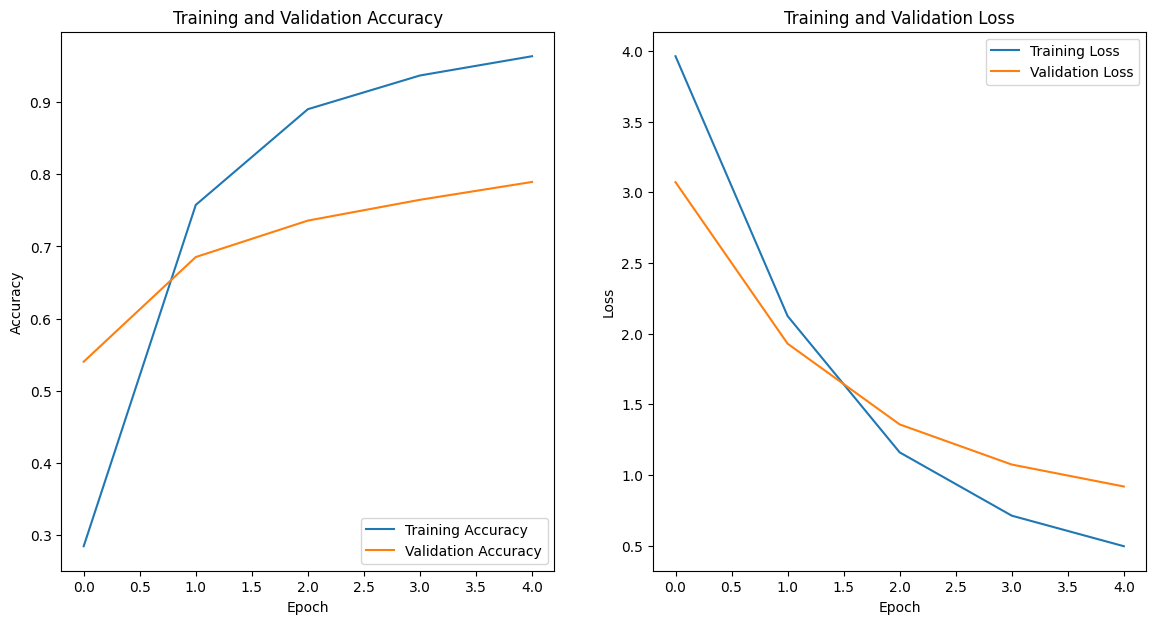

In [ ]:
def plot_model_loss_curves(history: tf.keras.callbacks.History) -> None:
  """Takes a History object and plots loss and accuracy curves."""

  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs_range = range(len(acc))

  plt.figure(figsize=(14, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label="Training Accuracy")
  plt.plot(epochs_range, val_acc, label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label="Training Loss")
  plt.plot(epochs_range, val_loss, label="Validation Loss")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.show()

plot_model_loss_curves(history=history_0)

In [ ]:
model_0_results = model_0.evaluate(x=test_ds)
model_0_results

269/269 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8370 - loss: 0.8284


[0.9189196228981018, 0.7892773747444153]

In [ ]:
model_0.metrics_names

['loss', 'compile_metrics']

## Model 1 - Training a model on 100% of the training data



In [ ]:
model_1 = create_model(num_classes=len(class_names),
                       model_name="model_1")

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

epochs=5
history_1 = model_1.fit(x=train_ds,
                        epochs=epochs,
                        validation_data=test_ds)

In [ ]:
plot_model_loss_curves(history=history_1)

In [ ]:
model_1_results = model_1.evaluate(test_ds)

## Evaluating predictions of the model


In [ ]:
test_preds = model_1.predict(test_ds)

In [ ]:
test_preds.shape

In [ ]:
import numpy as np

test_ds_images = np.concatenate([images for images, labels in test_ds], axis=0)
test_ds_labels = np.concatenate([labels for images, labels in test_ds], axis=0)

len(test_ds_images), len(test_ds_labels)

In [ ]:
accuracy_per_class = test_results_df.groupby("test_truth_class_name")["correct"].mean()

accuracy_per_class_df = pd.DataFrame(accuracy_per_class).reset_index().sort_values("correct", ascending=False)
accuracy_per_class_df.head()

In [ ]:
plt.figure(figsize=(10, 17))
plt.barh(y=accuracy_per_class_df["test_truth_class_name"],
         width=accuracy_per_class_df["correct"])
plt.xlabel("Accuracy")
plt.ylabel("Class Name")
plt.title("Dog Vision Accuracy per Class")
plt.ylim(-0.5, len(accuracy_per_class_df["test_truth_class_name"]) - 0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Confusion matrix




In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix_dog_preds = confusion_matrix(y_true=test_ds_labels_argmax,
                                              y_pred=test_preds_labels)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dog_preds,
                                                  display_labels=class_names)
fig, ax = plt.subplots(figsize=(25, 25))
ax.set_title("Dog Vision Confusion Matrix")
confusion_matrix_display.plot(xticks_rotation="vertical",
                              cmap="Blues",
                              colorbar=False,
                              ax=ax);